In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gamma, loggamma, spence
from scipy.special import factorial, factorial2

def histParam_kin(p_names,names,data,filename):
    for name in p_names:
        var_names = ["px","py","pz"]
        data_mom = data[names == name,5:]
        for j, var_name in enumerate(var_names):
            plt.figure()
            plt.hist(data_mom[:,j], bins=100)
            plt.xlabel(f'{var_name} (keV)')
            plt.ylabel('Counts')
            #plt.yscale('log')
            plt.title(name)
            plt.savefig(f'plots/{filename[6:-4]}_{name}_{var_name}.pdf')
        data_E = data[names == name,4]
        data_v = data_mom/data_E[:,np.newaxis]
        var_names2 = ["vx","vy","vz"]
        for j, var_name in enumerate(var_names2):
            plt.figure()
            plt.hist(data_v[:,j], bins=100)
            plt.xlabel(f'{var_name} (c)')
            plt.ylabel('Counts')
            #plt.yscale('log')
            plt.title(name)
            plt.savefig(f'plots/{filename[6:-4]}_{name}_{var_name}.pdf')
        if name in ['e+','e-']:
            data_dir = data_v/np.tile(np.linalg.norm(data_v,axis=1),(3,1)).T
            var_names3 = ["x_dir","y_dir","z_dir"]
            for j, var_name in enumerate(var_names3):
                plt.figure()
                plt.hist(data_dir[:,j], bins=100)
                plt.xlabel(f'{var_name}')
                plt.ylabel('Counts')
                #plt.yscale('log')
                plt.title(name)
                plt.savefig(f'plots/{filename[6:-4]}_{name}_{var_name}.pdf')

    chargedl_data = data[np.logical_or(names == 'e+',names == 'e-'),5:8]
    neutrino_data = data[np.logical_or(names == 'enu',names == 'enubar'),5:8]
    chargedl_data = chargedl_data/np.tile(np.linalg.norm(chargedl_data,axis=1),(3,1)).T
    neutrino_data = neutrino_data/np.tile(np.linalg.norm(neutrino_data,axis=1),(3,1)).T
    angle = np.sum(chargedl_data*neutrino_data,axis=1)
    plt.figure()
    plt.hist(angle, bins=100)
    plt.xlabel('cos(theta_{e,enu})')
    plt.ylabel('Counts')
    #plt.yscale('log')
    plt.savefig(f'plots/{filename[6:-4]}_angular_correlation_enu_e.pdf')
    

def phase_space(W, W0, **kwargs):
    """Phase space

    :param W: Electron energy in iunits of me c^2
    :param W0: Electron endpoint energy in units of me c^2

    """
    return np.sqrt(W**2-1)*(W-W0)**2*W

def fermi_function(W, Z, A, **kwargs):
    """Fermi Function

    :param Z: Proton number of the final nuclear state
    :param W: Electron energy in units of me c^2
    :param A: Mass number of the final (and initial) state
    """
    f = 1
    ALPHA = 0.0072973525643
    
    # R Nuclear radius in units of the electron Compton wavelength

    R = (1.15+1.8*A**(-2./3.)-1.2*A**(-4./3.))*A**(1./3.)*1e-15;
    R *= np.sqrt(5/3)/3.86159268e-13 
    
    if Z == 0:
        return f

    g = np.sqrt(1-(ALPHA*Z)**2)
    p = np.sqrt(W**2-1)
    y = ALPHA*Z*W/p
    
    #We use the Fermi function with 2(1+gamma), consistent with CRADLE
    f = (2*(g+1)
            *np.power(2*p*R, 2*(g-1))
            *np.exp(np.pi*y)
            *(np.abs(gamma(g+1.j*y))/(gamma(1+2*g)))**2)

    return f

In [2]:
mass_e = 510.9989461 #keV

class data_analysis:
    def __init__(self,fileName,betaType):
        data = np.genfromtxt(fileName, dtype=str)
        self.names = data[:,2]
        self.data = data[:, np.arange(data.shape[1]) != 2].astype(dtype=np.float32)
        self.events = data[:,0].astype(int)
        self.data[np.isnan(self.data)] = 0
        self.c_lepton = "e-" if (betaType == 1) else "e+"
        self.neutrino = "enubar" if (betaType == 1) else "enu"
    def __len__(self):
        return self.data.shape[0]
    def event_mask(self):
        pass
    def kinematical_data(self):
        #energy
        self.data_E_el = self.data[self.names == self.c_lepton ,4]
        
        #directions
        self.data_dir_el = self.data[self.names == self.c_lepton ,5:8]
        self.data_dir_el /= np.tile(np.linalg.norm(self.data_dir_el,axis=1),(3,1)).T
        self.data_dir_enu = self.data[self.names == self.neutrino ,5:8]
        self.data_dir_enu /= np.tile(np.linalg.norm(self.data_dir_enu,axis=1),(3,1)).T
        
        #angle between e and enu
        self.data_angle_elenu = np.sum(self.data_dir_el*self.data_dir_enu,axis=1)
     
    def kinematical_data_ref(self,polDir = np.array([0,0,1])):
        #angles in reference to polDir
        z_cross_elenu = np.sum(np.cross(self.data_dir_el,self.data_dir_enu)*polDir[np.newaxis,:],axis=1)
        self.cos_el = np.sum(self.data_dir_el*polDir[np.newaxis,:],axis=1)
        self.cos_enu = np.sum(self.data_dir_enu*polDir[np.newaxis,:],axis=1)
        sin_el = np.sqrt(1-self.cos_el**2)
        sin_enu = np.sqrt(1-self.cos_enu**2)
        data_cosphi = (self.data_angle_elenu-self.cos_el*self.cos_enu)/sin_el/sin_enu
        data_sinphi = z_cross_elenu/sin_el/sin_enu
        self.data_phi = np.arctan2(data_sinphi,data_cosphi)
    def plot_E_dist(self):
        print(self.data_E_el.size)
        plt.hist(self.data_E_el, bins=100)
        plt.xlabel('E')
        plt.ylabel('Counts')
        #plt.yscale('log')
        plt.title("e-")
    def theoretical_dist(self, coeffs):
        #note a, c, A, B and D need to be functions dependent on energy
        E_hist, E_bin = np.histogram(self.data_E_el, bins= 200)
        E_vals = (E_bin[1:]+E_bin[:-1])/2
        N = self.data_E_el.size

        z_el = np.linspace(-1,1,201)
        z_nu = z_el.copy()
        z_elenu = z_el.copy()
        phi = np.linspace(-np.pi,np.pi,501)

        self.z_el = z_el
        self.z_nu = z_nu
        self.z_elenu = z_elenu
        self.phi = phi
        
        self.z_el_theory = np.zeros_like(z_el)
        self.z_nu_theory = np.zeros_like(z_nu)
        self.z_elenu_theory = np.zeros_like(z_elenu)
        self.phi_theory = np.zeros_like(phi)

        for E, dist in zip(E_vals, E_hist):
            a, b, c, A, B, D = coeffs(E)
            beta = np.sqrt(1-mass_e**2/E**2)
            self.z_el_theory += dist/N*(1+b*mass_e/E+A*beta*z_el)/2/(1+b*mass_e/E) 
            self.z_elenu_theory += dist/N*(1+b*mass_e/E+a*beta*z_elenu)/2/(1+b*mass_e/E)
            self.z_nu_theory += dist/N*(1+b*mass_e/E+B*z_nu)/2/(1+b*mass_e/E)
            phi_theory_E = dist/N*(1 + b*mass_e/E + beta*((a+c/3)*np.cos(phi)+D*np.sin(phi))*(np.pi/4)**2)
            self.phi_theory += phi_theory_E/2/np.pi/(1+b*mass_e/E)

    def plot_kin_histograms(self,fileName):
        p_names = (set(self.names)&{'e+','e-','enubar','enu'})
        histParam_kin(p_names,self.names,self.data,fileName)
        plt.show()
    def plot_distribution_histograms(self,showTheory,bins=100,fileName=None):
        fig, axs = plt.subplots(2,2,figsize=(10,7))
        for ax in axs.flatten():
            ax.tick_params('both',labelsize = 14)
        axs[0,0].hist(self.cos_el, bins=bins,density=True) #z component
        if showTheory:
            axs[0,0].plot(self.z_el,self.z_el_theory,linewidth = 2)
        axs[0,0].set_xlabel("$\\cos \\theta_{e,j}$",size = 16)
        axs[0,0].set_ylabel('pdf',size = 16)
        #plt.yscale('log')
        axs[1,0].hist(self.cos_enu, bins=bins,density=True) #z component
        if showTheory: 
            axs[1,0].plot(self.z_nu,self.z_nu_theory,linewidth = 2)
        axs[1,0].set_xlabel("$\\cos \\theta_{\\nu,j}$",size = 16)
        axs[1,0].set_ylabel('pdf',size = 16)
        #plt.yscale('log')
        axs[0,1].hist(self.data_angle_elenu, bins=bins,density=True)
        if showTheory: 
            axs[0,1].plot(self.z_elenu,self.z_elenu_theory,linewidth = 2)
        axs[0,1].set_xlabel("$\\cos \\theta_{e,\\nu}$",size = 16)
        axs[0,1].set_ylabel('pdf',size = 16)
        #plt.yscale('log')
        axs[1,1].hist(self.data_phi, bins=bins,density=True)
        if showTheory: 
            axs[1,1].plot(self.phi,self.phi_theory,linewidth = 2)
        axs[1,1].set_xlabel("$\\phi$",size = 16)
        axs[1,1].set_ylabel('pdf',size = 16)
        #plt.yscale('log')
        fig.tight_layout()
        if fileName != None:
            fig.savefig(f"plots/{fileName}.png")
        plt.show()

In [3]:
mu_60Co = 3.799*3.152451e-8 #ev.T^-1
kb = 8.617e-5 #ev.K^-1
B = 1 #T
N = 200000

T = np.linspace(0.001,0.01,10)

mj_states = np.arange(-5,6)

p_states = np.exp(mu_60Co*B*mj_states[:,np.newaxis]/5/kb/T[np.newaxis,:])
print(p_states.shape)
Z = p_states.sum(axis=0)
print(Z.shape)
p_states /= Z[np.newaxis,:]
for i in range(10):
    print(p_states[:,i])

polz_list = np.sum(p_states*mj_states[:,np.newaxis]/5,axis=0)
Jzz = np.sum(p_states*mj_states[:,np.newaxis]**2,axis=0)
align_list = (3*Jzz-5*6)/5/9

print(polz_list)
print(align_list)

p_states_ext = np.exp(mu_60Co*B*mj_states/kb/1e-5)
Z_ext = p_states_ext.sum()
p_states_ext /= Z_ext
polz_ext = np.sum(p_states_ext*mj_states)/5
Jzz_ext = np.sum(p_states_ext*mj_states**2)
align_ext = (3*Jzz_ext-5*6)/5/9
print(p_states_ext,polz_ext,Jzz_ext,align_ext)

(11, 10)
(10,)
[0.01580321 0.02086721 0.02755393 0.03638334 0.04804206 0.06343672
 0.08376445 0.11060603 0.14604876 0.1928488  0.25464549]
[0.04127237 0.04742626 0.05449773 0.06262359 0.07196105 0.08269077
 0.09502033 0.10918829 0.12546876 0.14417672 0.16567412]
[0.05481846 0.06014043 0.06597908 0.07238456 0.0794119  0.08712149
 0.09557955 0.10485875 0.1150388  0.12620717 0.13845981]
[0.06270083 0.06721297 0.07204981 0.07723473 0.08279276 0.08875077
 0.09513754 0.10198391 0.10932297 0.11719018 0.12562352]
[0.06779506 0.07167074 0.07576798 0.08009944 0.08467853 0.08951939
 0.09463699 0.10004716 0.1057666  0.11181302 0.11820509]
[0.07134404 0.074727   0.07827037 0.08198176 0.08586913 0.08994084
 0.09420561 0.09867261 0.10335142 0.10825209 0.11338514]
[0.07395386 0.07694961 0.08006671 0.08331008 0.08668484 0.0901963
 0.09385001 0.09765172 0.10160743 0.10572338 0.11000606]
[0.07595206 0.07863745 0.08141779 0.08429644 0.08727686 0.09036265
 0.09355755 0.09686542 0.10029023 0.10383613 0.1075

199745


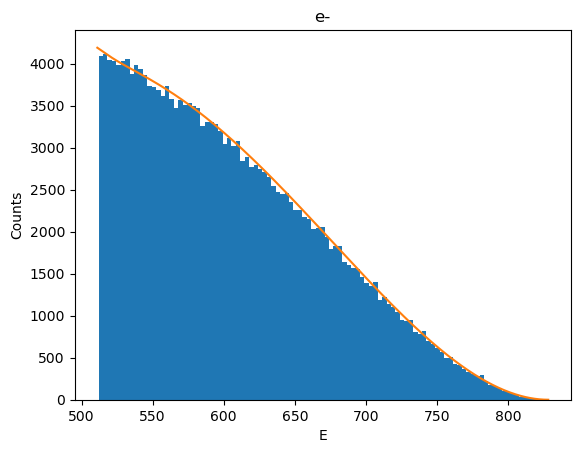

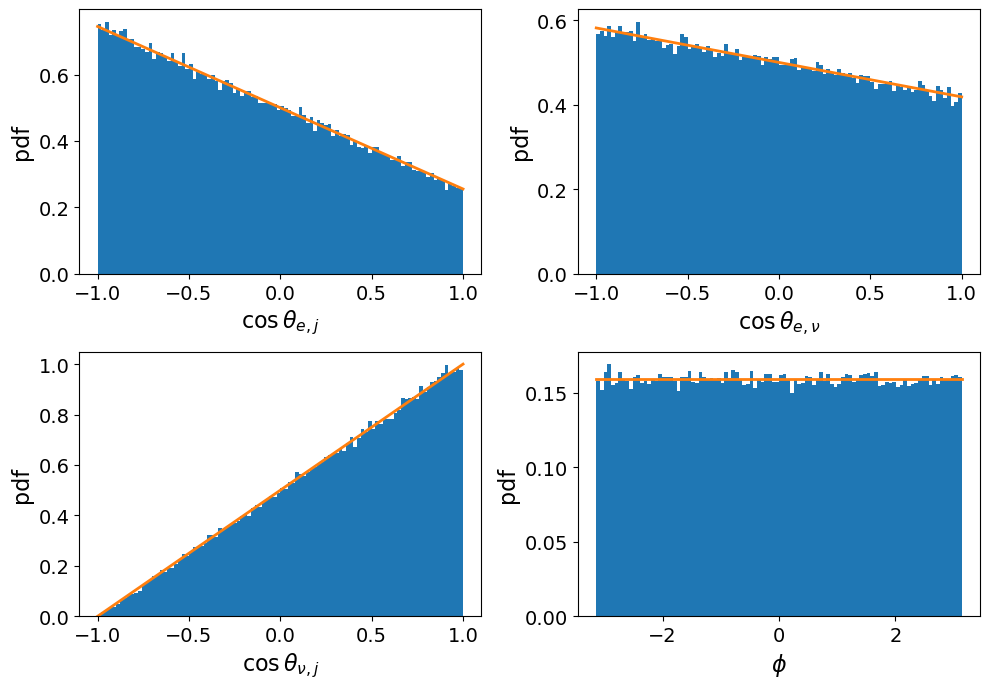

In [7]:
class Co60_data_analysis(data_analysis):
    def __init__(self, fileName):
        super().__init__(fileName, 1)
    def event_mask(self):
        part_events = np.bincount(self.events)
        events_mask = np.arange(part_events.size)[part_events == 5] #60Ni + e- + enu + 2 gamma
        self.data = self.data[np.isin(self.events, events_mask),:]
        self.names = self.names[np.isin(self.events, events_mask)]
    
#Standard Model Gamov-Teller

def SM_coeffs(E):
    return (-1/3, 0, 1, -1, 1, 0)

cos_lim = np.cos(15*np.pi/180)

W_0 = 317.05/mass_e + 1
E_range = np.linspace(mass_e+0.1,317.05+mass_e,400)
dist_E = []
av_beta = 0
for E in E_range:
    W = E/mass_e
    dist = phase_space(W,W_0)*fermi_function(W,28,60)
    dist_E.append(dist)
    av_beta += dist*np.sqrt(1-1/W**2)
dist_E = np.array(dist_E)
   
SM_60Co_polZpos = Co60_data_analysis("build/60Co_polZWu0.txt")
SM_60Co_polZpos.event_mask()
SM_60Co_polZpos.kinematical_data()
SM_60Co_polZpos.plot_E_dist()
plt.plot(E_range,dist_E/np.sum(dist_E)*getattr(SM_60Co_polZpos,"data_E_el").size*4)
plt.show()
SM_60Co_polZpos.kinematical_data_ref()
SM_60Co_polZpos.theoretical_dist(SM_coeffs)
SM_60Co_polZpos.plot_distribution_histograms(showTheory=True,bins=100)
el_zdist = getattr(SM_60Co_polZpos, "cos_el")
count_par = [np.sum(el_zdist > cos_lim)]
count_antipar = [np.sum(el_zdist < -cos_lim)]

In [8]:
for i in range(10):
    def SM_coeffs(E):
        return (-1/3, 0, align_list[i], -1*polz_list[i], polz_list[i], 0)
    print(i,T[i],np.exp(-mu_60Co*B/kb/T[i]),polz_list[i],align_list[i])
    
    SM_60Co_polZpos = Co60_data_analysis(f"build/60Co_polZWu{i+1}.txt")
    SM_60Co_polZpos.event_mask()
    SM_60Co_polZpos.kinematical_data()
    SM_60Co_polZpos.kinematical_data_ref()
    #SM_60Co_polZpos.theoretical_dist(SM_coeffs)
    #SM_60Co_polZpos.plot_distribution_histograms(showTheory=True,bins=100)
    el_zdist = getattr(SM_60Co_polZpos, "cos_el")
    count_par.append(np.sum(el_zdist > cos_lim))
    count_antipar.append(np.sum(el_zdist < -cos_lim))

0 0.001 0.24911775976341047 0.4843580039975993 0.16419079921275884
1 0.002 0.4991169800391592 0.26762247983601306 0.04754915242019548
2 0.003 0.6292186161760367 0.18215378086395256 0.021776269526661767
3 0.004 0.7064821158664664 0.13763698272474878 0.012381277557918381
4 0.005 0.7573226361526193 0.11049380917926657 0.007963802282151121
5 0.006 0.7932330150567591 0.09225343662247874 0.00554554733496878
6 0.007 0.8199211675287982 0.07916534797056948 0.004081012401022437
7 0.008 0.8405249049650262 0.06932148342702234 0.003127880227686654
8 0.009000000000000001 0.8569073233106697 0.06165072318495729 0.002473232440071153
9 0.01 0.8702428604433473 0.055506036515088994 0.0020043746714939123


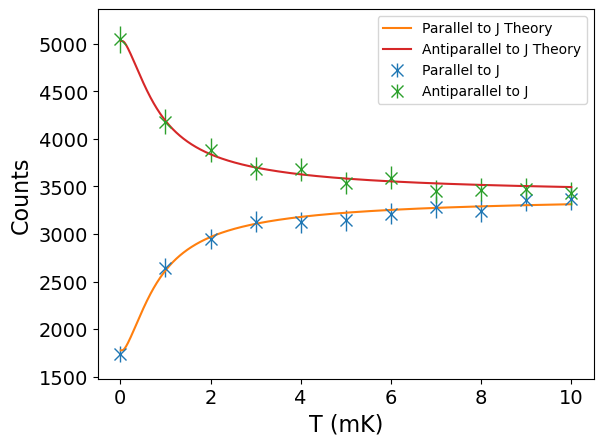

In [9]:
T_theory = np.linspace(0.00001,0.01,1000)
p_states_theory = np.exp(mu_60Co*B*mj_states[:,np.newaxis]/5/kb/T_theory[np.newaxis,:])
Z_theory = p_states_theory.sum(axis=0)
p_states_theory /= Z_theory[np.newaxis,:]
polz_list_theory = np.sum(p_states_theory*mj_states[:,np.newaxis]/5,axis=0)

#calculation of <beta>
W_0 = 317.05/mass_e + 1
E_range = np.linspace(mass_e+0.1,317.05+mass_e,400)
dist_E = []
av_beta = 0
for E in E_range:
    W = E/mass_e
    dist = phase_space(W,W_0)*fermi_function(W,28,60)
    dist_E.append(dist)
    av_beta += dist*np.sqrt(1-1/W**2)
dist_E = np.array(dist_E)
av_beta /= dist_E.sum()

polz_list_theory *= av_beta
count_par_theory = N*0.9988*(1-cos_lim)*(2-polz_list_theory*(1+cos_lim))/4
count_antipar_theory = N*0.9988*(1-cos_lim)*(2+polz_list_theory*(1+cos_lim))/4

T_plot = np.linspace(0,10,11)
fig, ax = plt.subplots()
count_par = np.array(count_par)
count_antipar = np.array(count_antipar)
ax.tick_params("both",labelsize=14)
ax.set_xlabel("T (mK)",size=16)
ax.set_ylabel("Counts",size=16)
ax.errorbar(T_plot,count_par,yerr=2*np.sqrt(count_par), linewidth = 0, elinewidth = 1, 
            marker = "x",markersize = 8,label = "Parallel to J")
ax.plot(T_theory*1e3,count_par_theory,label = "Parallel to J Theory")
ax.errorbar(T_plot,count_antipar,yerr=2*np.sqrt(count_antipar), linewidth = 0, elinewidth = 1, 
            marker = "x",markersize = 8,label = "Antiparallel to J")
ax.plot(T_theory*1e3,count_antipar_theory,label = "Antiparallel to J Theory")
ax.legend()
fig.savefig("plots/Wu_experiment.png")
plt.show()

In [ ]:
pol_vals_paper = [50.07,50.07,31.7,31.7,16.04,11.1] #mm
pol_vals_scale = 15.66 #mm = 0.1 pol
count_ratio_scale = 15.66 #mm = 0.1 pol
count_ratio_paper = [-28.72,28.62,-21.63,21.26,-18.74,16.78]